# Example of automatic fitting of anti-crossing

Pieter Eendebak <pieter.eendebak@tno.nl>

In [1]:
# import the modules used in this program:
import sys, os, time
import qcodes
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import scipy.optimize
import cv2
import qtt
import qtt.measurements
from qcodes.data.hdf5_format import HDF5Format
from qtt.algorithms.anticrossing import fit_anticrossing, plot_anticrossing

## Load dataset

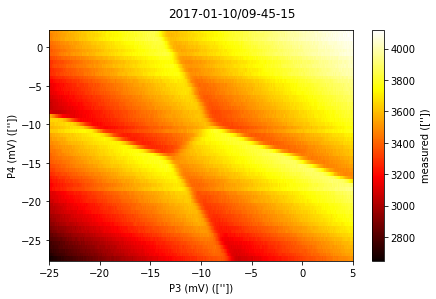

In [2]:
exampledatadir=os.path.join(qtt.__path__[0], 'exampledata')

qcodes.DataSet.default_io = qcodes.DiskIO(exampledatadir)
data = qcodes.load_data('2017-01-10/09-45-15', formatter=HDF5Format())

qtt.measurements.scans.plotData(data, fig=10)

In [3]:
fit_results = fit_anticrossing(data)

straightenImage: size (60, 928) fx 0.1294 fy 2.0000
straightenImage: result size (120, 120) mvx 0.2500 mvy 0.2500
fitModel: score 1618.90 -> 1297.85
fitModel: score 1297.85 -> 1297.85
fit_anticrossing: patch size (60, 60)


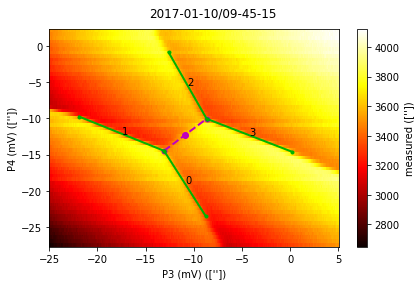

In [4]:
plot_anticrossing(data, fit_results)

In [5]:
print(fit_results)

{'labels': ['P4', 'P3'], 'centre': array([[-10.87211769],
       [-12.26915977]]), 'fitpoints': {'centre': array([[-10.87211769],
       [-12.26915977]]), 'lp': array([[-13.08208812],
       [-14.4791302 ]]), 'hp': array([[ -8.66214727],
       [-10.05918935]]), 'ip': array([[-13.08208812, -13.08208812,  -8.66214727,  -8.66214727,
        -24.87058186],
       [-14.4791302 , -14.4791302 , -10.05918935, -10.05918935,
          2.15483141]]), 'op': array([[ -8.75028798, -21.89994276, -12.61640843,   0.23548363],
       [-23.49220446,  -9.76262306,  -0.87421147, -14.62341595]])}, 'fit_params': array([13.99846417, 14.42399118,  3.12537015,  1.12277831,  3.63275451,
        4.30585725,  0.47397048]), 'params': {}}


## Detailed steps

### Pre-process image to a honeycomb

In [6]:
from qtt.algorithms.images import straightenImage
from qtt.utilities.imagetools import cleanSensingImage
from qtt.utilities.tools import showImage as showIm
from qtt.measurements.scans import fixReversal
from qtt.utilities.imagetools import fitModel, evaluateCross

fitBackground: is1d 0, order 3
 checkReversal: 1 (mval 0.1, thr -0.4)
straightenImage: size (60, 928) fx 0.1294 fy 2.0000
straightenImage: result size (120, 120) mvx 0.2500 mvy 0.2500


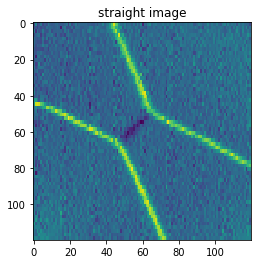

In [7]:
im, tr = qtt.data.dataset2image(data)
imextent = tr.scan_image_extent()
mpl_imextent =tr.matplotlib_image_extent()
istep=.25

#im = fixReversal(im, verbose=1) # cleanSensingImage already does fixReversal
imc = cleanSensingImage(im, sigma=0.93, verbose=1)
imx, (fw, fh, mvx, mvy, Hstraight) = straightenImage(imc, imextent, mvx=istep, verbose=2) 

imx = imx.astype(np.float64)*(100./np.percentile(imx, 99)) # scale image

showIm(imx, fig=100, title='straight image')

### Initial input

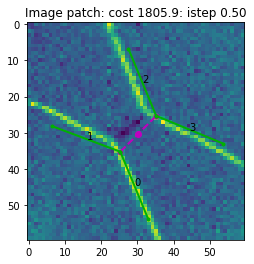

In [8]:
istepmodel = .5
ksizemv = 31
#samplesize = [int(ksizemv / istepmodel), int(ksizemv / istepmodel)] #not used
param0 = [(imx.shape[0] / 2 + .5) * istep, (imx.shape[0] / 2 + .5) * istep, \
          3.5, 1.17809725, 3.5, 4.3196899, 0.39269908]
param0e = np.hstack((param0, [np.pi / 4]))
#param0e[0]-=2; param0e[2]=3
cost, patch, r, _ = evaluateCross(param0e, imx, verbose=0, fig=21, istep=istep, istepmodel=istepmodel)

### Find the anti-crossing

fitModel: score 1618.90 -> 1297.58
calculation time: 3.80 [s]
evaluateCross: patch shape (60, 60)
  add cost for image cc: 2.0


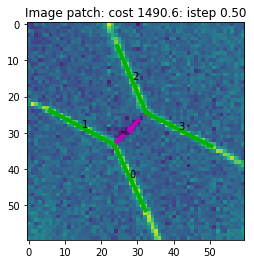

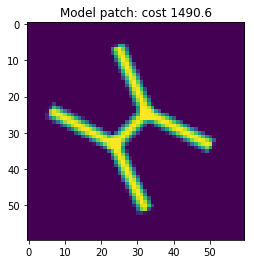

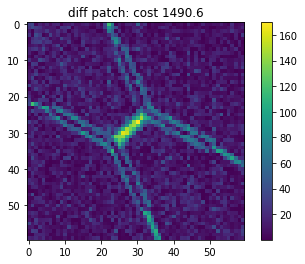

evaluateCross: cost 1490.5542


In [9]:
t0 = time.time()
res = qtt.utilities.imagetools.fitModel(param0e, imx, verbose=1, cfig=10, istep=istep,
                   istepmodel=istepmodel, ksizemv=ksizemv, w=2.5, use_abs=True)
param = res.x
dt = time.time() - t0
print('calculation time: %.2f [s]' % dt)

cost, patch, cdata, _ = evaluateCross(param, imx, verbose=1, fig=25, istep=istep, istepmodel=istepmodel, linewidth=4)

### Show orthogonal line (for polarization scan)

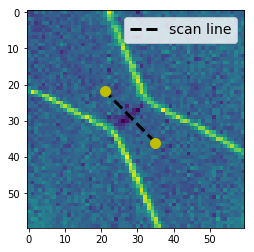

In [10]:
showIm(patch, fig=25)
ppV, ccV, slopeV = qtt.utilities.imagetools.Vtrace(cdata, param, fig=25)